## House Prices - Advanced Regression Techniques

Kaggle competiotion practice
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from scipy.special import boxcox1p
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

### Exploarory data analysis

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

# Split ID is 1461

df = pd.concat([df_train, df_test], axis=0)
df.reset_index(inplace=True, drop=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

#### Regressed variable

c:\Users\Lenovo\anaconda3\envs\myenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

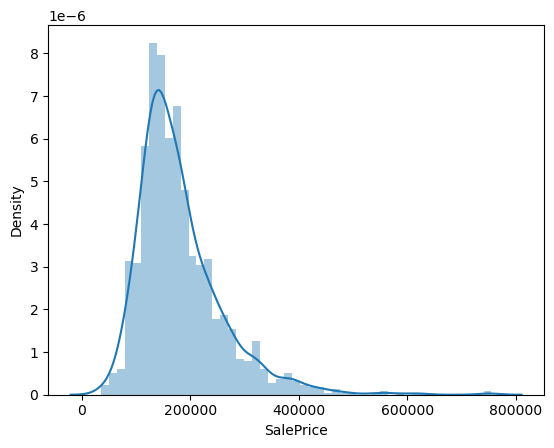

In [4]:
sns.distplot(df["SalePrice"])

The data looks like it's skewed more towards the smaller values. To fix this, we can use a log-transformation on the data. 

In [5]:
df["SalePrice"] = df.apply(lambda x: np.log(x["SalePrice"]) if pd.notnull(x["SalePrice"]) else np.nan, axis=1)


#### Overall data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [7]:
null_counts = df.isnull().sum()
null_counts_sorted = null_counts.sort_values(ascending=False)
null_counts_sorted[null_counts_sorted > 0]

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageQual       159
GarageCond       159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
Functional         2
BsmtHalfBath       2
BsmtFullBath       2
Utilities          2
BsmtFinSF1         1
BsmtFinSF2         1
SaleType           1
Electrical         1
GarageCars         1
TotalBsmtSF        1
GarageArea         1
Exterior2nd        1
Exterior1st        1
KitchenQual        1
BsmtUnfSF          1
dtype: int64

For this case, sometimes the missing values are tricky in particular the ones with a lot, because the NA actually represents no

In [8]:
df["PoolQC"] = df["PoolQC"].fillna(value="No")
df["MiscFeature"] = df["MiscFeature"].fillna(value="No")
df["Alley"] = df["Alley"].fillna(value="No")
df["Fence"] = df["Fence"].fillna(value="No")
df["FireplaceQu"] = df["FireplaceQu"].fillna(value="No")

#### Continuous data

In [9]:
cont_cols = df.select_dtypes(exclude=['object']).columns
cont_cols = list(cont_cols)
cont_cols.remove("Id")
cont_cols.remove("SalePrice")


In [10]:
nunique_values = df[cont_cols].nunique()
summary_stats = df[cont_cols].describe().T
summary_stats['nunique'] = nunique_values
summary_stats

,count,mean,std,min,25%,50%,75%,max,nunique
MSSubClass,2919.0,57.137718,42.517628,20.0,20.0,50.0,70.0,190.0,16
LotFrontage,2433.0,69.305795,23.344905,21.0,59.0,68.0,80.0,313.0,128
LotArea,2919.0,10168.114080,7886.996359,1300.0,7478.0,9453.0,11570.0,215245.0,1951
OverallQual,2919.0,6.089072,1.409947,1.0,5.0,6.0,7.0,10.0,10
OverallCond,2919.0,5.564577,1.113131,1.0,5.0,5.0,6.0,9.0,9
YearBuilt,2919.0,1971.312778,30.291442,1872.0,1953.5,1973.0,2001.0,2010.0,118
YearRemodAdd,2919.0,1984.264474,20.894344,1950.0,1965.0,1993.0,2004.0,2010.0,61
MasVnrArea,2896.0,102.201312,179.334253,0.0,0.0,0.0,164.0,1600.0,444
BsmtFinSF1,2918.0,441.423235,455.610826,0.0,0.0,368.5,733.0,5644.0,991
BsmtFinSF2,2918.0,49.582248,169.205611,0.0,0.0,0.0,0.0,1526.0,272


In [11]:
# Odd value in GarageYrBlt
odd_filt = df["GarageYrBlt"] > 2020

index = df[odd_filt].index
df.loc[index, 'GarageYrBlt'] = 2007

In [12]:
# Null values
null_counts = df[cont_cols].isnull().sum()
null_counts_sorted = null_counts.sort_values(ascending=False)
null_counts_sorted[null_counts_sorted > 0]

LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtHalfBath      2
BsmtFullBath      2
TotalBsmtSF       1
GarageCars        1
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
GarageArea        1
dtype: int64

**Filling the missing values by interpolation**

In [13]:
df["LotFrontage"] = df["LotFrontage"].interpolate(method='cubic', limit_direction='both')
df["GarageYrBlt"] = df["GarageYrBlt"].interpolate(method='cubic', limit_direction='both')

The MasVnrArea the same, no sense in replacing missing values by interpolation, the non-existance of the value indicates that it is not present, so an area of 0.

In [14]:
df["MasVnrArea"] = df["MasVnrArea"].fillna(value=0.0)

**Filling the missing values by mean values**

In [15]:
cols_mean_fill = ["BsmtHalfBath", "BsmtFullBath", "TotalBsmtSF", "GarageCars", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "GarageArea"]
imp1 = SimpleImputer(strategy="mean")
for cmf in cols_mean_fill:
    df[cmf] = imp1.fit_transform(df[[cmf]])


There are some continous columns that need to be classified as categories not continuous

In [16]:
not_conts = ["MSSubClass", 'OverallQual', 'OverallCond', "BsmtFullBath",\
     "BsmtHalfBath", "FullBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr",\
           "TotRmsAbvGrd", "Fireplaces", "GarageCars", "MoSold", "YrSold"]

label_encoder = LabelEncoder()
for col in not_conts:
    df[col] = label_encoder.fit_transform(df[col])
    df[col] = df[col].astype('category')

#### Categorical columns analysis

In [17]:
cat_cols = df_train.select_dtypes(['object']).columns
cat_cols

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [18]:
null_counts = df[cat_cols].isnull().sum()
null_counts_sorted = null_counts.sort_values(ascending=False)
null_counts_sorted[null_counts_sorted > 0] 

GarageCond      159
GarageQual      159
GarageFinish    159
GarageType      157
BsmtExposure     82
BsmtCond         82
BsmtQual         81
BsmtFinType2     80
BsmtFinType1     79
MasVnrType       24
MSZoning          4
Functional        2
Utilities         2
Electrical        1
SaleType          1
KitchenQual       1
Exterior1st       1
Exterior2nd       1
dtype: int64

In [19]:
df["GarageCond"] = df["GarageCond"].fillna(value="No")
df["GarageQual"] = df["GarageQual"].fillna(value="No")
df["GarageFinish"] = df["GarageFinish"].fillna(value="No")
df["GarageType"] = df["GarageType"].fillna(value="No")
df["BsmtExposure"] = df["BsmtExposure"].fillna(value="No")
df["BsmtCond"] = df["BsmtCond"].fillna(value="No")
df["BsmtQual"] = df["BsmtQual"].fillna(value="No")
df["BsmtFinType2"] = df["BsmtFinType2"].fillna(value="No")
df["BsmtFinType1"] = df["BsmtFinType1"].fillna(value="No")
df["MasVnrType"] = df["MasVnrType"].fillna(value="No")

In [20]:
cols_most_freq_fill = ["MSZoning", "Utilities", "Functional", "SaleType", "Electrical", "KitchenQual"]
imp2 = SimpleImputer(strategy="most_frequent")
for cmff in cols_most_freq_fill:
    df[cmff] = imp2.fit_transform(df[[cmff]])

In [21]:
for col in cat_cols:
    df[col] = label_encoder.fit_transform(df[col])
    df[col] = df[col].astype('category')

### Model
The implemented model demonstrates the capability to seamlessly handle both categorical and continuous variables. Leveraging this versatility, the data loader intelligently dissects the input data into distinct categories of categorical and continuous variables. Additionally, it dynamically calculates the embedding size, ensuring optimal utilization of resources and efficient representation of categorical data. This innovative approach empowers the model to efficiently process diverse types of input features, enhancing its flexibility and adaptability across various real-world scenarios.

#### Data Loader

In [22]:
class CustomDataLoader:
    def __init__(self, data, target, cat_cols=None, cont_cols=None, val_size=0.05, test_size=0.1, batch_size=2048):  
        self.batch_size = batch_size
        
        # Preprocess categorical variables 
        cats = []
        for cat in cat_cols:
            data[cat] = data[cat].astype('category')
            vec = data[cat].cat.codes.values
            cats.append(vec)
        cats = np.stack(cats, 1)
        
        cat_szs = [len(data[col].cat.categories) for col in cat_cols]
        self.emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
        
        # Preprocess continuous variables
        conts = []
        for con in cont_cols:
            vec = data[con].values
            conts.append(vec)
        conts = np.stack(conts, 1)

        # Concatenate categorical and continuous variables
        X = np.hstack((cats, conts))
        
        # Split data into train, validation, and test sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(X, target.values, test_size=test_size, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size/(1-test_size), random_state=42)

        # Separate categorical and continuous variables
        self.cat_train, self.cat_val, self.cat_test = X_train[:, :cats.shape[1]], X_val[:, :cats.shape[1]], X_test[:, :cats.shape[1]]
        self.cont_train, self.cont_val, self.cont_test = X_train[:, cats.shape[1]:], X_val[:, cats.shape[1]:], X_test[:, cats.shape[1]:]
        self.y_train, self.y_val, self.y_test = y_train, y_val, y_test

    def get_data_loaders(self):
        # Combine categorical and continuous features with target into one TensorDataset
        train_dataset = TensorDataset(
            torch.tensor(self.cat_train, dtype=torch.long), 
            torch.tensor(self.cont_train, dtype=torch.float32),
            torch.tensor(self.y_train, dtype=torch.float32))
        val_dataset = TensorDataset(
            torch.tensor(self.cat_val, dtype=torch.long), 
            torch.tensor(self.cont_val, dtype=torch.float32),
            torch.tensor(self.y_val, dtype=torch.float32))
        test_dataset = TensorDataset(
            torch.tensor(self.cat_test, dtype=torch.long), 
            torch.tensor(self.cont_test, dtype=torch.float32),
            torch.tensor(self.y_test, dtype=torch.float32))

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        return train_loader, val_loader, test_loader

filt = df["Id"] < 1461
df1 = df[filt]

X = df1.drop(columns=["SalePrice"])
y = df1["SalePrice"]
cat_cols = list(df1.select_dtypes(include=['category']).columns)
cont_cols = list(df1.select_dtypes(include=['int', 'float']).columns)
cont_cols.remove("Id")
cont_cols.remove("SalePrice")
custom_loader = CustomDataLoader(X, y, cat_cols, cont_cols)
train_loader, val_loader, test_loader = custom_loader.get_data_loaders()

#### Neural Network 

In [23]:
class Model(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x



# Define input and output sizes
model = Model(custom_loader.emb_szs, len(cont_cols), 1, [200, 100, 100], p=0.5) 
print(model)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

Model(
  (embeds): ModuleList(
    (0): Embedding(16, 8)
    (1): Embedding(5, 3)
    (2): Embedding(2, 1)
    (3): Embedding(3, 2)
    (4-5): 2 x Embedding(4, 2)
    (6): Embedding(2, 1)
    (7): Embedding(5, 3)
    (8): Embedding(3, 2)
    (9): Embedding(25, 13)
    (10): Embedding(9, 5)
    (11): Embedding(8, 4)
    (12): Embedding(5, 3)
    (13): Embedding(8, 4)
    (14): Embedding(10, 5)
    (15): Embedding(9, 5)
    (16): Embedding(6, 3)
    (17): Embedding(8, 4)
    (18): Embedding(16, 8)
    (19): Embedding(17, 9)
    (20): Embedding(5, 3)
    (21): Embedding(4, 2)
    (22): Embedding(5, 3)
    (23): Embedding(6, 3)
    (24-25): 2 x Embedding(5, 3)
    (26): Embedding(4, 2)
    (27-28): 2 x Embedding(7, 4)
    (29): Embedding(6, 3)
    (30): Embedding(5, 3)
    (31): Embedding(2, 1)
    (32-33): 2 x Embedding(5, 3)
    (34): Embedding(4, 2)
    (35): Embedding(5, 3)
    (36): Embedding(3, 2)
    (37): Embedding(8, 4)
    (38-39): 2 x Embedding(4, 2)
    (40): Embedding(14, 7)
 

### Training

Epoch 1/5000, Train Loss: 147.5826, Test Loss: 168.5062
Epoch 2/5000, Train Loss: 169.1424, Test Loss: 163.8339
Epoch 3/5000, Train Loss: 164.4607, Test Loss: 158.4526
Epoch 4/5000, Train Loss: 159.0689, Test Loss: 152.7724
Epoch 5/5000, Train Loss: 153.3720, Test Loss: 146.9816
Epoch 6/5000, Train Loss: 147.5419, Test Loss: 141.3604
Epoch 7/5000, Train Loss: 141.8874, Test Loss: 135.8268
Epoch 8/5000, Train Loss: 136.3475, Test Loss: 130.2941
Epoch 9/5000, Train Loss: 130.8008, Test Loss: 124.7800
Epoch 10/5000, Train Loss: 125.2720, Test Loss: 119.3222
Epoch 11/5000, Train Loss: 119.7976, Test Loss: 113.9456
Epoch 12/5000, Train Loss: 114.4138, Test Loss: 108.6854
Epoch 13/5000, Train Loss: 109.1536, Test Loss: 103.5579
Epoch 14/5000, Train Loss: 104.0353, Test Loss: 98.5716
Epoch 15/5000, Train Loss: 99.0557, Test Loss: 93.7154
Epoch 16/5000, Train Loss: 94.2014, Test Loss: 88.9716
Epoch 17/5000, Train Loss: 89.4543, Test Loss: 84.3627
Epoch 18/5000, Train Loss: 84.8567, Test Loss: 

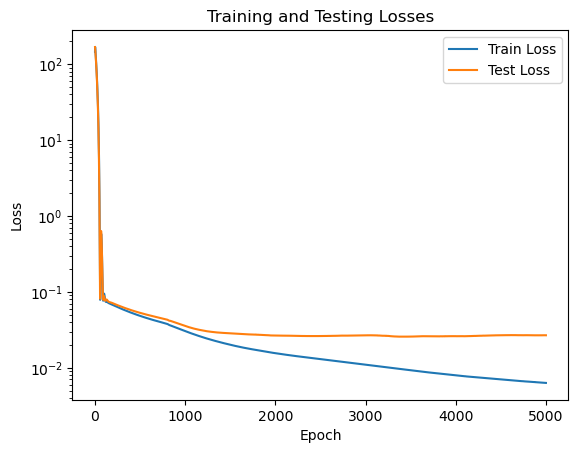

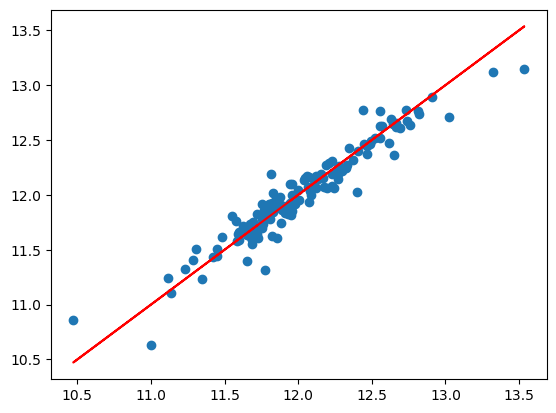

0.9162756246145848

In [24]:
class Trainer:
    def __init__(self, model, optimizer, criterion, train_loader, val_loader):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_loader = train_loader
        self.val_loader = val_loader
    
    def train(self, max_epochs):
        self.train_losses = []
        self.val_losses = []

        # Training
        for epoch in range(max_epochs):
            self.model.train
            train_loss = 0

            for cat_inputs, cont_inputs, labels in self.train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(cat_inputs, cont_inputs)
                loss = self.criterion(outputs.squeeze(), labels)  # Assuming output shape is [batch_size, 1]
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item() * cat_inputs.size(0)
            train_loss /= len(self.train_loader.dataset)
            self.train_losses.append(train_loss)

            # Validation
            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for cat_inputs, cont_inputs, labels in self.val_loader:
                    outputs = self.model(cat_inputs, cont_inputs)
                    loss = self.criterion(outputs.squeeze(), labels)
                    val_loss += loss.item() * cat_inputs.size(0)
                val_loss /= len(self.val_loader.dataset)
            self.val_losses.append(val_loss)

            if epoch % 1 == 0:
                print(f'Epoch {epoch+1}/{max_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {val_loss:.4f}')
 
        return self.model
    
    def plot_losses(self, train_losses, test_losses):
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.yscale('log')  # Set y-axis scale to logarithmic
        plt.title('Training and Testing Losses')
        plt.legend()
        plt.show()
    
    def evaluation(self, model, test_loader):
        model.eval()
        with torch.no_grad():
            test_preds = []
            test_targets = []
            for cat_inputs, cont_inputs, labels in test_loader:
                outputs = model(cat_inputs, cont_inputs)
                test_preds.extend(outputs.squeeze().tolist())
                test_targets.extend(labels.tolist())
        test_r2 = r2_score(test_targets, test_preds)
        plt.plot(test_targets, test_targets, color="red")
        plt.scatter(test_targets, test_preds)
        plt.show()

        return test_r2
            

trainer = Trainer(model, optimizer, criterion, train_loader, val_loader)   
model = trainer.train(int(5e3))      
trainer.plot_losses(trainer.train_losses, trainer.val_losses)
trainer.evaluation(model, test_loader)

In [25]:
class CustomDataLoader:
    def __init__(self, data, cat_cols=None, cont_cols=None):  
       
        # Preprocess categorical variables 
        cats = []
        for cat in cat_cols:
            data[cat] = data[cat].astype('category')
            vec = data[cat].cat.codes.values
            cats.append(vec)
        self.cats = np.stack(cats, 1)
        
        cat_szs = [len(data[col].cat.categories) for col in cat_cols]
        self.emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
        
        # Preprocess continuous variables
        conts = []
        for con in cont_cols:
            vec = data[con].values
            conts.append(vec)
        self.conts = np.stack(conts, 1)


    def get_data_loaders(self):
        test_dataset = TensorDataset(
            torch.tensor(self.cats, dtype=torch.long), 
            torch.tensor(self.conts, dtype=torch.float32))

        # Create data loaders
        test_loader = DataLoader(test_dataset, shuffle=False)

        return test_loader

filt = df["Id"] < 1461
df1 = df[~filt]

X = df1.drop(columns="SalePrice")
cat_cols = list(df1.select_dtypes(include=['category']).columns)
cont_cols = list(df1.select_dtypes(include=['int', 'float']).columns)
cont_cols.remove("Id")
cont_cols.remove("SalePrice")
custom_loader = CustomDataLoader(X,cat_cols, cont_cols)
test_loader = custom_loader.get_data_loaders()

In [26]:
model.eval()
with torch.no_grad():
    test_preds = []
    for cat_inputs, cont_inputs in test_loader:
        outputs = model(cat_inputs, cont_inputs)
        outputs = torch.exp(outputs.squeeze()).detach().numpy()
        test_preds.append(outputs.item())


In [27]:
# Create a DataFrame
df_out = pd.DataFrame({
    'Id': range(1461, 1461 + len(test_preds)),
    'SalePrice': test_preds
})

In [28]:
df_out.to_csv('submission.csv', index=False)
